In [241]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Cleaning data

In [242]:
df = pd.read_csv('../data/raw/data.csv')
df.drop(columns=['latitude', 'longitude', 'Unnamed: 0'], inplace=True)
df.head()

C:\Users\bedo7\AppData\Local\Temp\ipykernel_11488\3265609756.py:1: DtypeWarning: Columns (14,46,47,48,49,51,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/data.csv')


,facility_name,facility_id,reporting_year,total_co2_emissions,total_ch4_emissions,total_n2o_emissions,compressor_not_operating_mode,compressor_operating_mode,compressor_standby_mode,as_found_measurement_conducted,...,total_equip_leaks_during_year,does_fac_have_flare_stacks,does_fac_have_high_bleed_devic,does_fac_have_intr_bleed_devic,does_fac_have_low_bleed_device,Not-operating_Isolation valve_r,Operating_Blowdown valve_r,Operating_Rod packing,Standby-pressurized_Blowdown valve,total_ghg_emissions
0,Bernville Station,1000179.0,2013.0,0.7,573.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,573.9
1,Bernville Station,1000179.0,2013.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,Bernville Station,1000179.0,2013.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,Bernville Station,1000179.0,2013.0,4.7,4114.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4119.2
4,Bernville Station,1000179.0,2013.0,0.1,106.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.8


Dropping null values

In [243]:
def drop_columns_by_threshold(df, threshold=0.8):
    missing_percentage = df.isnull().mean()
    df_cleaned = df.loc[:, missing_percentage <= threshold]
    dropped_columns = [col for col in df.columns if col not in df_cleaned.columns]
    return dropped_columns, df_cleaned

dropped_columns, df_cleaned = drop_columns_by_threshold(df)
print('dropped_columns: ', dropped_columns)

dropped_columns:  ['compressor_not_operating_mode', 'compressor_operating_mode', 'compressor_standby_mode', 'measurement_flow_rate', 'measurement_location', 'measurement_method', 'percent_time_dev_operational', 'pneu_est_no_of_hours', 'pneu_dev_total_count', 'pneumatic_device_type', 'equipment_type_bd', 'total_blowdowns_equip_type', 'total_CH4_CO2e_bd', 'total_CO2_CO2e_bd', 'measurement_date', 'compressor_id', 'number_of_blowdowns', 'Unit Name', 'maximum_rated_heat_input_capacity', 'compressor_driver_power_output', 'compressor_identifier', 'compressor_measured_no_op_mode', 'compressor_measured_op_mode', 'had_scheduled_shutdown', 'number_of_wet_seals', 'seal_type', 'total_not_operating_mode_hours', 'total_operating_mode_hours', 'miles_of_trans_pipe', 'quantity_gas_added', 'quantity_gas_consumed', 'quantity_gas_received', 'quantity_gas_transferred', 'quantity_gas_withdrawn', 'quantity_of_gas_injected', 'quantity_of_gas_withdrawn', 'total_storage_capacity']


In [244]:
def clean_objects(df, threshold=100):
    # Select object columns
    object_columns = df.select_dtypes(include=[object]).columns

    # Create a dictionary to store unique counts and their levels
    unique_counts_levels = {}

    # Loop through each object column to get unique counts and levels
    for col in object_columns:
        unique_counts_levels[col] = {
            'unique_count': df[col].nunique(),
            'levels': df[col].unique()
        }
    to_remove_columns = []
    unique_counts_levels
    for key in unique_counts_levels.keys():
        if unique_counts_levels[key]['unique_count'] > threshold:
            to_remove_columns.append(key)
    df_filtered = df.drop(columns=to_remove_columns)

    return df_filtered, to_remove_columns, unique_counts_levels

df_cleaned_by_level, _, unique_counts_levels = clean_objects(df_cleaned, 50)

In [245]:
def fillnull_with_threshold(df, threshold):
    for column in df.columns:
        null_percentage = df[column].isnull().mean()
        if null_percentage < threshold:
            fill_value = 0
        else:
            fill_value = df[column].median()
        df[column].fillna(fill_value, inplace=True)
    return df
df_filled = fillnull_with_threshold(df_cleaned_by_level, 10)

### Label encoding the string features

In [246]:
df_imputed = pd.get_dummies(df_filled)

C:\Users\bedo7\AppData\Local\Temp\ipykernel_11488\4267731139.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_filled.corr()


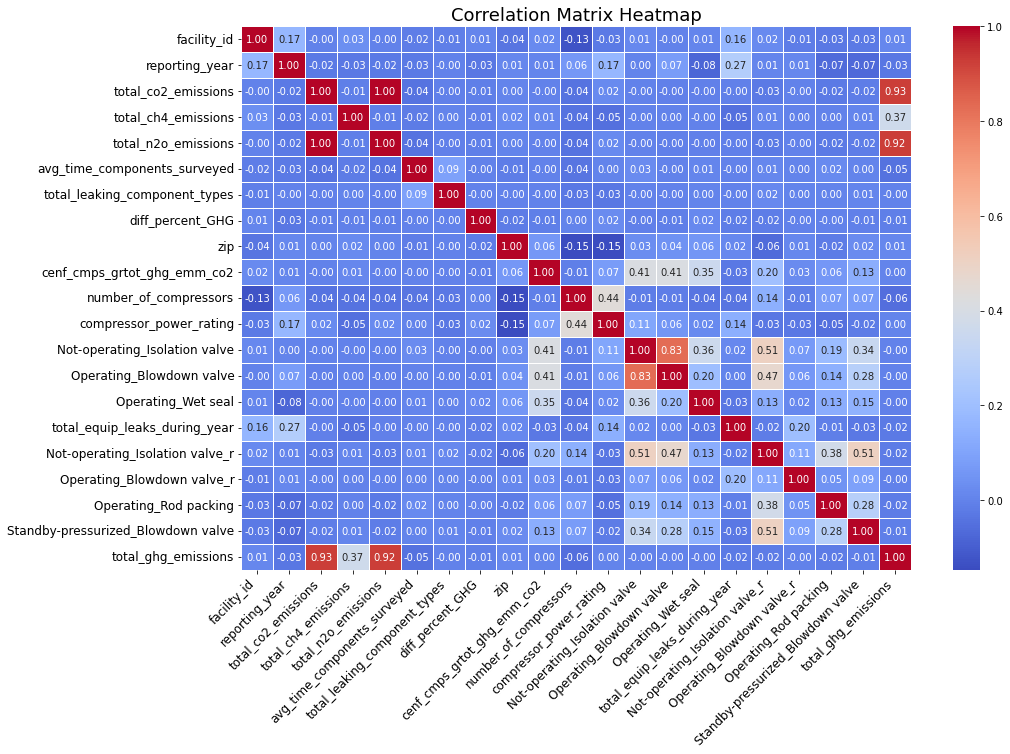

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns
# numerical = df_filled.select_dtypes(exclude=[object])

# Create a correlation matrix
corr_matrix = df_filled.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create the heatmap with annotations and color bar
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, linecolor='white')

# Add titles and labels
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Display the heatmap
plt.show()

# 

In [248]:
df_imputed.set_index('reporting_year', inplace=True)


In [251]:
df_imputed

,facility_id,total_co2_emissions,total_ch4_emissions,total_n2o_emissions,avg_time_components_surveyed,total_leaking_component_types,diff_percent_GHG,zip,cenf_cmps_grtot_ghg_emm_co2,number_of_compressors,...,opticalgasimaging60_5397a_0,opticalgasimaging60_5397a_True,does_fac_have_flare_stacks_0,does_fac_have_flare_stacks_True,does_fac_have_high_bleed_devic_0,does_fac_have_high_bleed_devic_True,does_fac_have_intr_bleed_devic_0,does_fac_have_intr_bleed_devic_True,does_fac_have_low_bleed_device_0,does_fac_have_low_bleed_device_True
reporting_year,,,,,,,,,,,,,,,,,,,,,
2013.0,1000179.0,0.70000,573.20000,0.000,0.0,0.0,0.000613,19551.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
2013.0,1000179.0,0.00000,0.00000,0.000,0.0,0.0,0.000613,19551.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
2013.0,1000179.0,0.00000,0.00000,0.000,0.0,0.0,0.000613,19551.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
2013.0,1000179.0,4.70000,4114.50000,0.000,0.0,0.0,0.000613,19551.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
2013.0,1000179.0,0.10000,106.70000,0.000,0.0,0.0,0.000613,19551.0,0.0,0.0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022.0,1014728.0,0.00000,0.00000,0.000,0.0,0.0,0.001666,77662.0,0.0,4.0,...,0,1,1,0,0,1,0,1,0,1
2022.0,1014728.0,0.00000,0.00000,0.000,0.0,0.0,0.001666,77662.0,0.0,4.0,...,0,1,1,0,0,1,0,1,0,1
2022.0,1014728.0,0.08679,75.24000,0.000,0.0,0.0,0.001666,77662.0,0.0,4.0,...,0,1,1,0,0,1,0,1,0,1
